In [1]:
import functools
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
from matplotlib.animation import FuncAnimation
from tqdm.auto import trange

sys.path.append("..")

from burgers.approximator import BurgersApproximator
from burgers.plot import plot_1d_image, plot_2d
from burgers.trajectory import IsDivergingPrecise, compare_trajectory
from neural_rk.grid_graph import dxdy2pos, edge2dxdy, node2grid
from neural_rk.hyperparameter import HyperParameter
from neural_rk.modules import RungeKutta, prune_state_dict
from neural_rk.path import DATA_DIR, FIG_DIR, RESULT_DIR
from neural_rk.scheduler import get_scheduler
from neural_rk.trainer import rollout

In [4]:
device = torch.device("cuda:1")
exp_id = "gwqokkyv"
test_id = "IC_test"
result_dir = RESULT_DIR / f"burgers_{exp_id}"

# Load hyperparameter
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")

# Load checkpoint
checkpoint = torch.load(result_dir / "best.pth", map_location=device)

# Load MAE
mae_df = pd.read_csv(result_dir / "mae.txt", sep="\t")
train_mae, val_mae = mae_df["train_mae"], mae_df["val_mae"]
rollout_mae = mae_df["rollout_mae"]
best_epoch = np.argmin(rollout_mae).item()

# Load test data
test_df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
times = np.stack(  # [num_sample, S+1]
    [np.insert(np.cumsum(dts.numpy()), 0, 0.0) for dts in test_df.dts], axis=0
)

# [num_sample, S+1, N(Nx*Ny), 2]
true_trajectories = np.stack([traj.numpy() for traj in test_df.trajectories], axis=0)

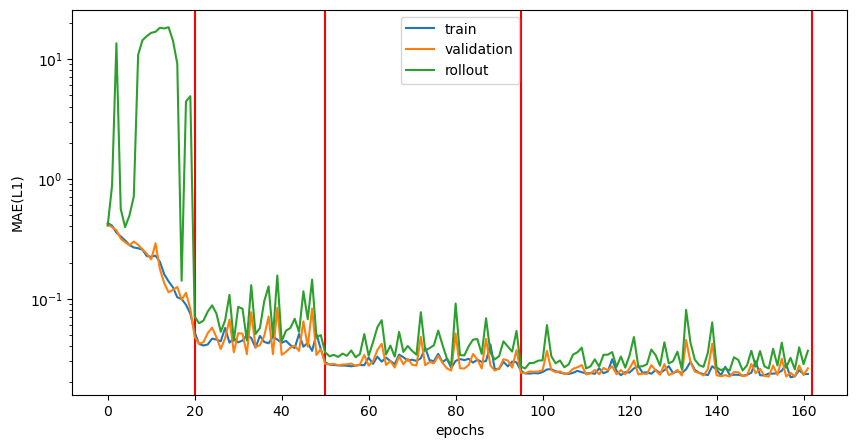

In [6]:
# Plot train history
fig, ax = plt.subplots(figsize=(10, 5))

schedular = get_scheduler(hp.scheduler)
for cycle in schedular.get_updated_epochs(hp.scheduler, len(train_mae)):
    plt.axvline(cycle, color="r")

ax.plot(train_mae, label="train")
ax.plot(val_mae, label="validation")
ax.plot(rollout_mae, label="rollout")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE(L1)")
ax.set_yscale("log")
ax.legend()

fig.show()

# Rollout

In [5]:
approximator = BurgersApproximator.from_hp(hp.approximator)
approximator.load_state_dict(prune_state_dict(checkpoint["best_model_state_dict"]))
model = RungeKutta(approximator, butcher_tableau=hp.rk).to(device)
# model = RungeKutta(approximator, butcher_tableau="rk4").to(device)

burgers_rollout = functools.partial(
    rollout,
    model=model,
    use_amp=hp.amp,
    device=device,
    is_diverging=IsDivergingPrecise(),
)

pred_trajectories: list[npt.NDArray[np.float32]] = []
for idx in trange(len(test_df)):
    pred_trajectories.append(burgers_rollout(series=test_df.iloc[idx]).cpu().numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
# with open(result_dir / f"pred_{test_id}.pkl", "wb") as f:
#     pickle.dump(pred_trajectories, f)

with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
    pred_trajectories = pickle.load(f)

# Analyze

In [8]:
maes = []
for idx, (true, pred) in enumerate(zip(true_trajectories, pred_trajectories)):
    print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
    maes.append(compare_trajectory(true, pred))
maes = np.stack(maes, axis=0)  # [num_sample, S, 2]
print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

idx=0, 100_100, N=10000 MAE: 0.0045, Maximum err: 0.0296 at step=462, node=109, field=v
idx=1, 100_100, N=10000 MAE: 0.0061, Maximum err: 0.0388 at step=307, node=176, field=v
idx=2, 100_100, N=10000 MAE: 0.0049, Maximum err: 0.0301 at step=760, node=9086, field=v
idx=3, 100_100, N=10000 MAE: 0.0051, Maximum err: 0.0358 at step=215, node=9984, field=v
idx=4, 100_100, N=10000 MAE: 0.0061, Maximum err: 0.0504 at step=349, node=1849, field=u
idx=5, 100_100, N=10000 MAE: 0.0045, Maximum err: 0.0297 at step=285, node=2605, field=u
idx=6, 100_100, N=10000 MAE: 0.0061, Maximum err: 0.0443 at step=606, node=3441, field=v
idx=7, 100_100, N=10000 MAE: 0.0054, Maximum err: 0.0273 at step=1998, node=6708, field=u
idx=8, 100_100, N=10000 MAE: 0.0037, Maximum err: 0.0267 at step=300, node=5397, field=u
idx=9, 100_100, N=10000 MAE: 0.0028, Maximum err: 0.0270 at step=224, node=60, field=u
idx=10, 100_100, N=10000 MAE: 0.0054, Maximum err: 0.0477 at step=273, node=1472, field=u
idx=11, 100_100, N=1000

In [10]:
# true_trajectories: list[npt.NDArray[np.float32]] = [traj.numpy() for traj in test_df.trajectories]

# maes = []
# for idx, true in enumerate(true_trajectories):
#     print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
#     dummy = np.stack([true[0] for _ in range(len(true))], axis=0)
#     maes.append(compare_trajectory(true, dummy))
# maes = np.stack(maes, axis=0)  # (# of samples, S, 3)
# print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

# Statistics over samples

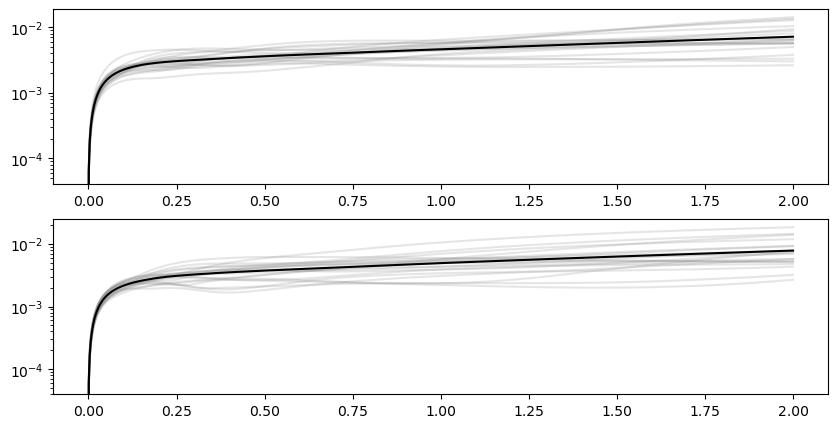

In [14]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=2)

for sample_time, sample_mae in zip(times, maes):
    ax1.plot(sample_time, sample_mae[..., 0], color="gray", alpha=0.2)
    ax2.plot(sample_time, sample_mae[..., 1], color="gray", alpha=0.2)

t = np.linspace(0.0, times[:, -1].mean(), len(times[0]), dtype=np.float32)
final_mae = np.mean(maes, axis=0)
ax1.plot(t, final_mae[..., 0], color="k")
ax2.plot(t, final_mae[..., 1], color="k")

ax1.set_yscale("log")
ax2.set_yscale("log")
fig.show()

# Single sample

In [15]:
sample_idx = 0
test_data = test_df.iloc[sample_idx]
Nx, Ny = map(int, str(test_data.network_type).split("_"))

time = times[sample_idx]    # [S+1, ]
true_trajectory = true_trajectories[sample_idx]  # [N, 2]
pred_trajectory = pred_trajectories[sample_idx]  # [N, 2]
error = true_trajectory - pred_trajectory   # [N, 2]
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min():.4f}, {error.max():.4f}")


MAE=4.4921e-03, in range -0.0296, 0.0280


### 1D

In [8]:
(dx,) = edge2dxdy(test_data.edge_attr, Nx)
pos = dxdy2pos(dx)

true_trajectory = true_trajectory[..., 0:1]
pred_trajectory = pred_trajectory[..., 0:1]
error = error[..., 0:1]
print(f"{error.max():.2e}, {error.min():.2e}")


2.09e-03, -8.43e-04


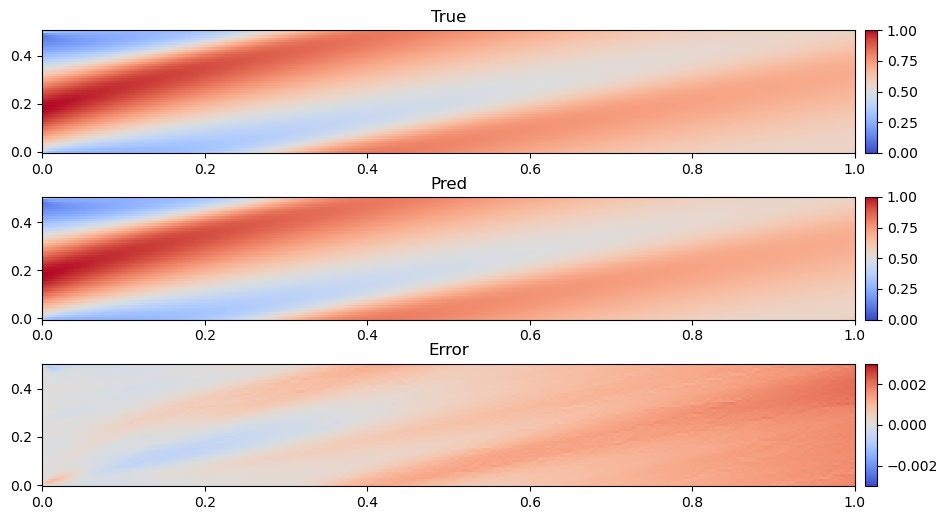

In [10]:


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)

im1 = plot_1d_image(ax1, time, pos, true_trajectory, rasterized=True)
ax1.set_title("True")
cbar1 = fig.colorbar(im1, ax=ax1, location="right", pad=0.01, aspect=10)

im2 = plot_1d_image(ax2, time, pos, pred_trajectory, rasterized=True)
ax2.set_title("Pred")
cbar2 = fig.colorbar(im2, ax=ax2, location="right", pad=0.01, aspect=10)

im3 = plot_1d_image(ax3, time, pos, error, lim=(-0.003, 0.003), rasterized=True)
ax3.set_title("Error")
cbar3 = fig.colorbar(im3, ax=ax3, location="right", pad=0.01, aspect=10)

fig.tight_layout(pad=0.0)
fig.show()

### 2D

In [17]:
dx, dy = edge2dxdy(test_data.edge_attr, Nx, Ny)
pos = dxdy2pos(dx, dy)
xticks = np.linspace(0, pos.shape[1] - 1, num=5)
xticklabels = np.round(np.linspace(0.0, pos[0, -1, 0], num=len(xticks)), 2)
yticks = np.linspace(0, pos.shape[0] - 1, num=5)
yticklabels = np.round(np.linspace(0.0, pos[-1, 0, 1], num=len(yticks)), 2)

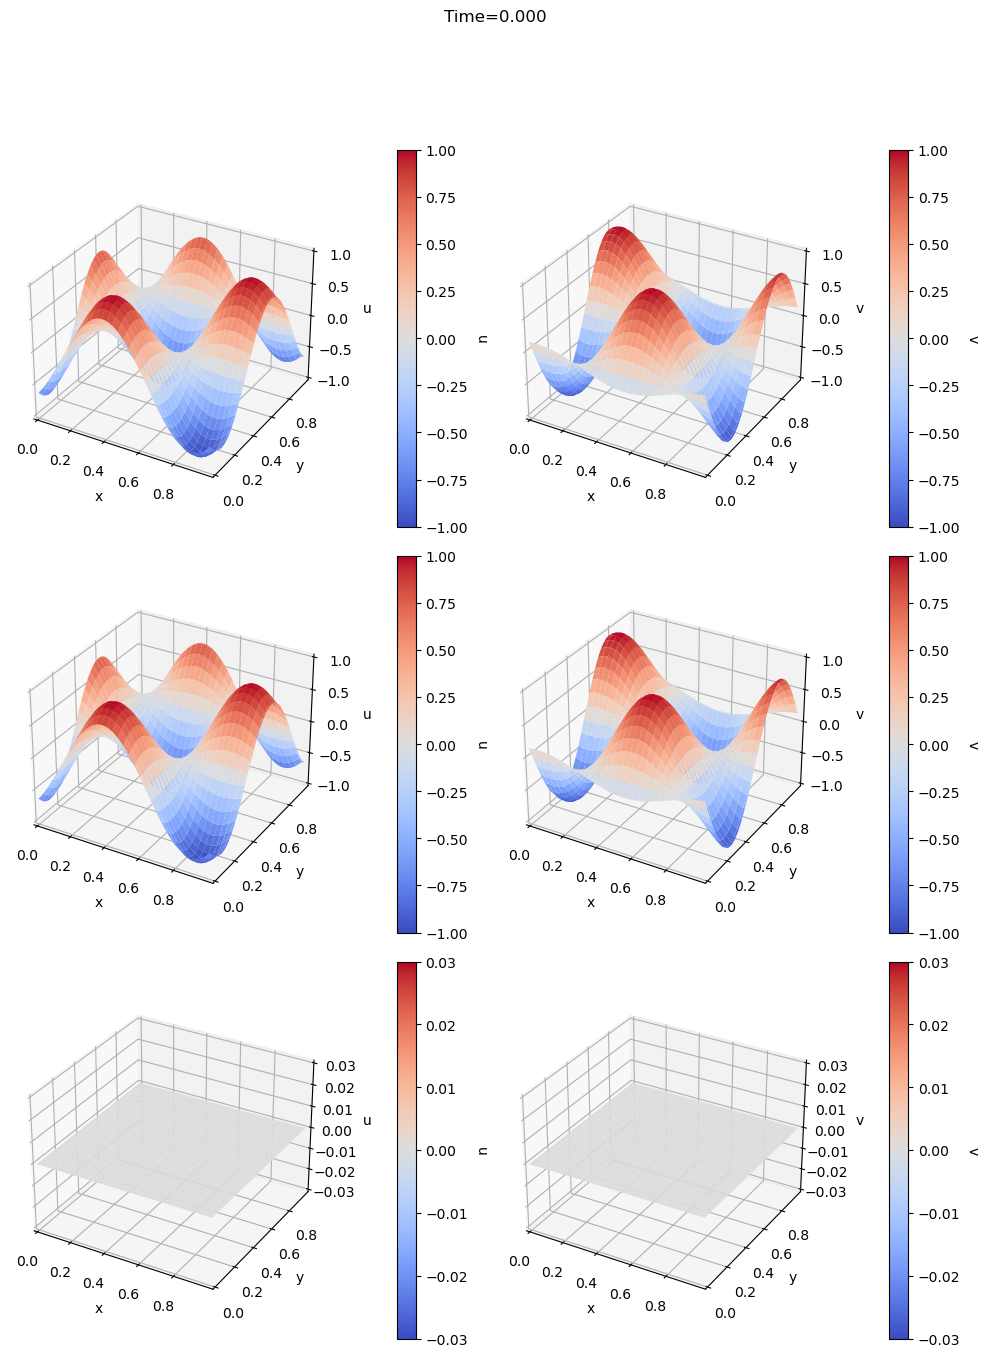

In [17]:
skip_frame = 10

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(321, projection="3d")
ax2 = fig.add_subplot(322, projection="3d")
ax3 = fig.add_subplot(323, projection="3d")
ax4 = fig.add_subplot(324, projection="3d")
ax5 = fig.add_subplot(325, projection="3d")
ax6 = fig.add_subplot(326, projection="3d")

ax1.set_title("True")
sf1, sf2 = plot_2d(ax1, ax2, pos, node2grid(true_trajectory[0], Nx, Ny))
cbar1 = ax1.figure.colorbar(sf1, ax=ax1, shrink=0.6, pad=0.15)
cbar1.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar2 = ax2.figure.colorbar(sf2, ax=ax2, shrink=0.6, pad=0.15)
cbar2.ax.set_ylabel("v", rotation=-90, va="bottom")


ax3.set_title("Pred")
sf3, sf4 = plot_2d(ax3, ax4, pos, node2grid(pred_trajectory[0], Nx, Ny))
cbar3 = ax3.figure.colorbar(sf3, ax=ax3, shrink=0.6, pad=0.15)
cbar3.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar4 = ax4.figure.colorbar(sf4, ax=ax4, shrink=0.6, pad=0.15)
cbar4.ax.set_ylabel("v", rotation=-90, va="bottom")

ax5.set_title("Error")
sf5, sf6 = plot_2d(ax5, ax6, pos, node2grid(error[0], Nx, Ny), lim=(-0.03, 0.03))
cbar5 = ax5.figure.colorbar(sf5, ax=ax5, shrink=0.6, pad=0.15)
cbar5.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar6 = ax6.figure.colorbar(sf6, ax=ax6, shrink=0.6, pad=0.15)
cbar6.ax.set_ylabel("v", rotation=-90, va="bottom")
fig.tight_layout()


def update(frame: int) -> None:
    frame *= skip_frame
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    plot_2d(ax1, ax2, pos, node2grid(true_trajectory[frame], Nx, Ny))
    plot_2d(ax3, ax4, pos, node2grid(pred_trajectory[frame], Nx, Ny))
    plot_2d(ax5, ax6, pos, node2grid(error[frame], Nx, Ny), lim=(-0.03, 0.03))
    fig.suptitle(f"Time={time[frame]:.3f}")
    fig.tight_layout()


anim = FuncAnimation(fig, update, frames=int(len(pred_trajectory) / skip_frame), interval=50)
anim.save(str(FIG_DIR / f"burgers_{test_id}_{sample_idx}_{exp_id}.gif"))